In [36]:
#importing
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [37]:
#inputs
altitude = ctrl.Antecedent(np.arange(0, 11, 0.1), 'altitude')
vertical_speed = ctrl.Antecedent(np.arange(0, 3.1, 0.09), 'vertical_speed')
landing_pad_alignment = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'landing_pad_alignment')
wind_stability = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'wind_stability')
#outputs
throttle_adjutment = ctrl.Consequent(np.arange(-1, 1.1, 0.1), 'throttle_adjutment')
position_correction_intensity = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'position_correction_intensity')

### Defining the Fuzzy Sets

## for Altitude

In [40]:
altitude['low'] = fuzz.zmf(altitude.universe, 0 , 2)
altitude['medium'] = fuzz.trimf(altitude.universe, [1.5 , 3.5 , 6])
altitude['high'] = fuzz.smf(altitude.universe, 5 , 10)

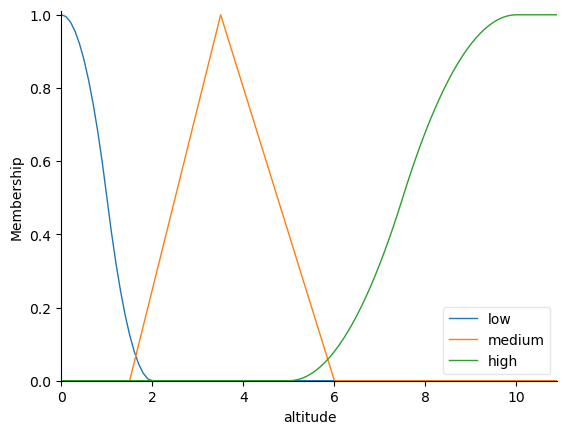

In [41]:
altitude.view()

## for Vertical Speed(Descent Rate)

In [43]:
vertical_speed['slow'] = fuzz.zmf(vertical_speed.universe, 0 , 1)
vertical_speed['moderate'] = fuzz.trimf(vertical_speed.universe, [0.5 , 1.25 , 2])
vertical_speed['fast'] = fuzz.smf(vertical_speed.universe, 1.5 , 3) 

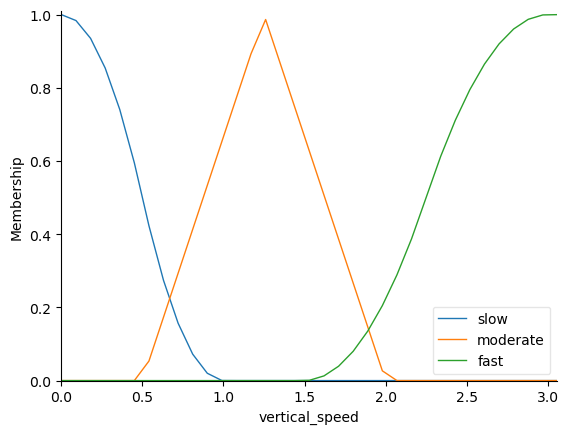

In [44]:
vertical_speed.view()

## for Landing Pad Alignment Error

In [59]:
landing_pad_alignment['aligned'] = fuzz.trapmf(landing_pad_alignment.universe, [0,0,0.1,0.2])
landing_pad_alignment['slightly off'] = fuzz.trimf(landing_pad_alignment.universe, [0.1 , 0.3 , 0.5])
landing_pad_alignment['misaligned'] = fuzz.trapmf(landing_pad_alignment.universe, [0.4,0.6,1,1])

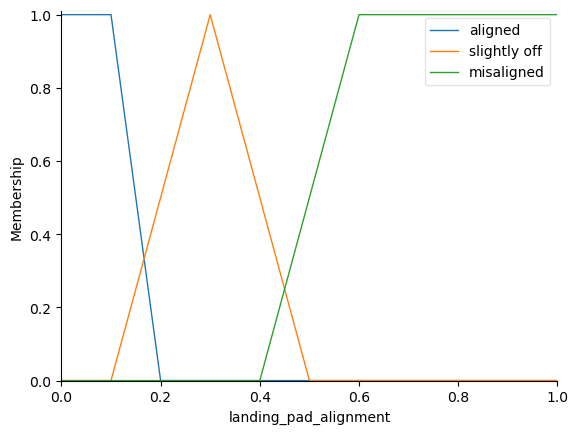

In [61]:
landing_pad_alignment.view()

## for Wind Stability

In [64]:
wind_stability['stable'] = fuzz.zmf(wind_stability.universe, 0 , 0.3)
wind_stability['unstable'] = fuzz.smf(wind_stability.universe, 0.2 , 1)

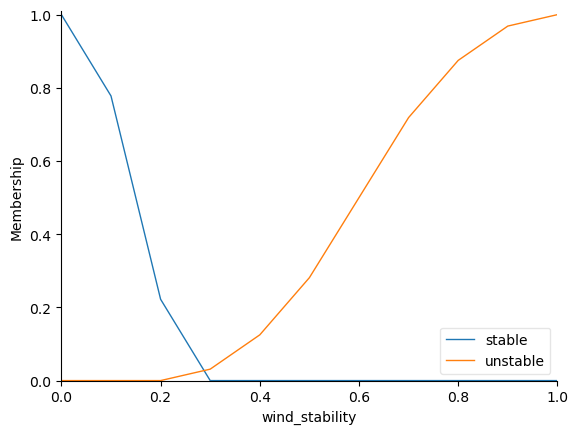

In [66]:
wind_stability.view()

## for Throttle Adjustment

In [69]:
throttle_adjutment['decrease'] = fuzz.zmf(throttle_adjutment.universe, -1 , -0.3)
throttle_adjutment['maintain'] = fuzz.gaussmf(throttle_adjutment.universe, 0, 0.2)
throttle_adjutment['increase'] = fuzz.smf(throttle_adjutment.universe, 0.3 , 1)

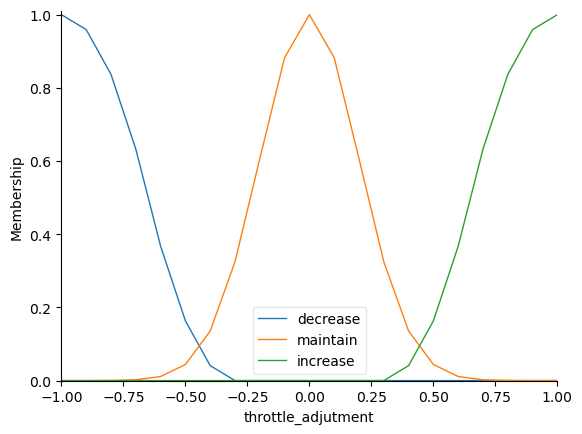

In [71]:
throttle_adjutment.view()

## for Position correction Intensity

In [74]:
position_correction_intensity['none'] = fuzz.zmf(position_correction_intensity.universe, 0 , 0.1)
position_correction_intensity['slight'] = fuzz.trimf(position_correction_intensity.universe,[0.1,0.3,0.5])
position_correction_intensity['strong'] = fuzz.trapmf(position_correction_intensity.universe, [0.4,0.7,1,1])

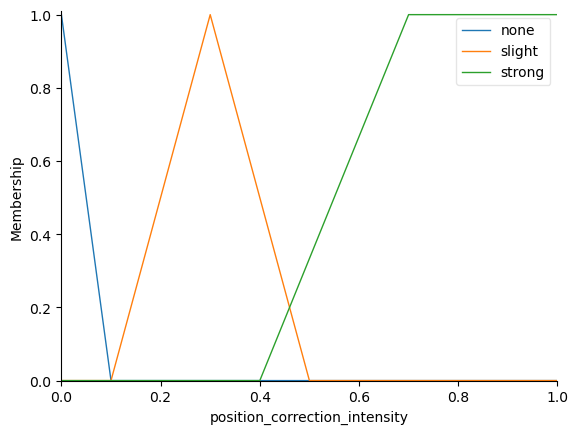

In [76]:
position_correction_intensity.view()

## Fuzzy Rules

In [79]:
rules = []

alt_vals = ['low', 'medium', 'high']
speed_vals = ['slow', 'moderate', 'fast']
align_vals = ['aligned', 'slightly off', 'misaligned']
wind_vals = ['stable', 'unstable']


In [81]:
for a in alt_vals:
    for s in speed_vals:
        for l in align_vals:
            for w in wind_vals:
                # Decision logic for outputs
                if a == 'low' and s == 'slow' and l == 'aligned' and w == 'stable':
                    t_out = 'maintain'
                    p_out = 'none'
                elif a == 'low' and l == 'misaligned':
                    t_out = 'increase'
                    p_out = 'strong'
                elif a == 'low':
                    t_out = 'maintain'
                    p_out = 'slight'
                elif a == 'medium' and s == 'moderate' and l == 'aligned':
                    t_out = 'maintain'
                    p_out = 'none'
                elif a == 'medium':
                    t_out = 'maintain'
                    p_out = 'slight' if l == 'slightly off' else 'strong'
                elif a == 'high' and s == 'fast':
                    t_out = 'decrease'
                    p_out = 'none' if l == 'aligned' else 'slight'
                else:
                    t_out = 'decrease'
                    p_out = 'slight' if l == 'aligned' else 'strong'

                rule = ctrl.Rule(
                    altitude[a] & vertical_speed[s] & landing_pad_alignment[l] & wind_stability[w],
                    (throttle_adjutment[t_out], position_correction_intensity[p_out])
                )
                rules.append(rule)

#54 rules

## experiments and results

In [84]:
landing_ctrl = ctrl.ControlSystem(rules)

In [85]:
landing_sim1 = ctrl.ControlSystemSimulation(landing_ctrl)
landing_sim2 = ctrl.ControlSystemSimulation(landing_ctrl)

## 1st experiment: Low altitude, slow descent, well aligned, stable wind

In [89]:
# Input values
landing_sim1.input['altitude'] = 1
landing_sim1.input['vertical_speed'] = 0.5
landing_sim1.input['landing_pad_alignment'] = 0.1
landing_sim1.input['wind_stability'] = 0.1

In [91]:

try:
    landing_sim1.compute()
    throttle_result1 = landing_sim1.output['throttle_adjutment']
    correction_result1 = landing_sim1.output['position_correction_intensity']
except ValueError:
    throttle_result1 = 0  # fallback: maintain
    correction_result1 = 0  # fallback: none

print("Experiment 1: Altitude=1, Vertical Speed=0.5, Alignment=0.1, Wind=0.1")
print("Throttle Adjustment:", throttle_result1)
print("Position Correction:", correction_result1)


Experiment 1: Altitude=1, Vertical Speed=0.5, Alignment=0.1, Wind=0.1
Throttle Adjustment: -8.323596788079167e-18
Position Correction: 0.10092066224774451


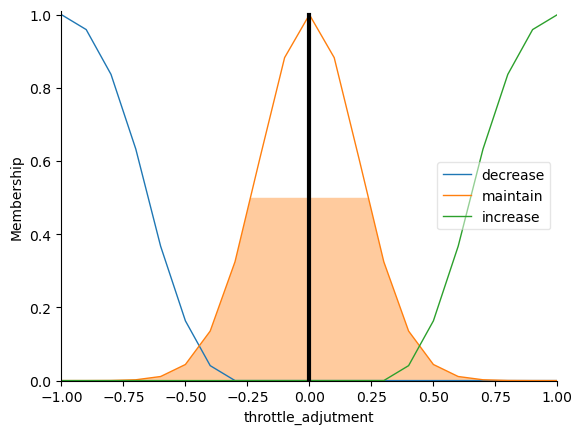

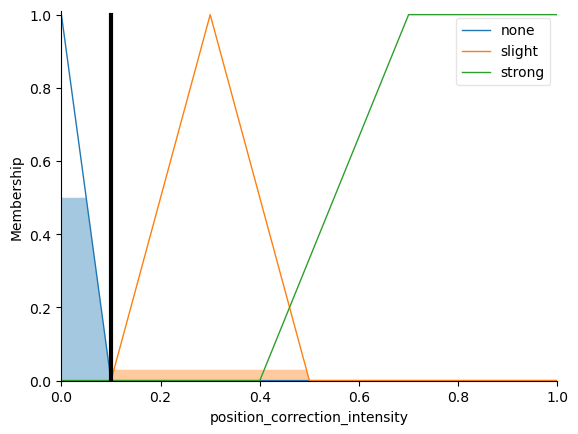

In [93]:
throttle_adjutment.view(sim=landing_sim1)
position_correction_intensity.view(sim=landing_sim1)

## 2nd experiment:  High altitude, fast descent, misaligned, unstable wind

In [95]:
landing_sim2.input['altitude'] = 9
landing_sim2.input['vertical_speed'] = 2.8
landing_sim2.input['landing_pad_alignment'] = 0.8
landing_sim2.input['wind_stability'] = 0.9

In [96]:
try:
    landing_sim2.compute()
    throttle_result2 = landing_sim2.output['throttle_adjutment']
    correction_result2 = landing_sim2.output['position_correction_intensity']
except ValueError:
    throttle_result2 = -1  # fallback: decrease
    correction_result2 = 1  # fallback: strong

print("\nExperiment 2: Altitude=9, Vertical Speed=2.8, Alignment=0.8, Wind=0.9")
print("Throttle Adjustment:", throttle_result2)
print("Position Correction:", correction_result2)


Experiment 2: Altitude=9, Vertical Speed=2.8, Alignment=0.8, Wind=0.9
Throttle Adjustment: -0.7904989009909305
Position Correction: 0.3


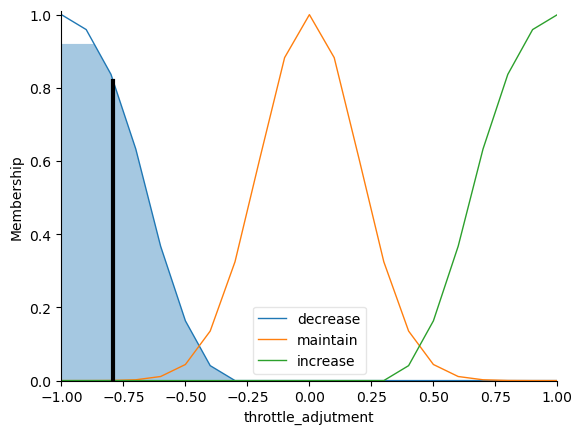

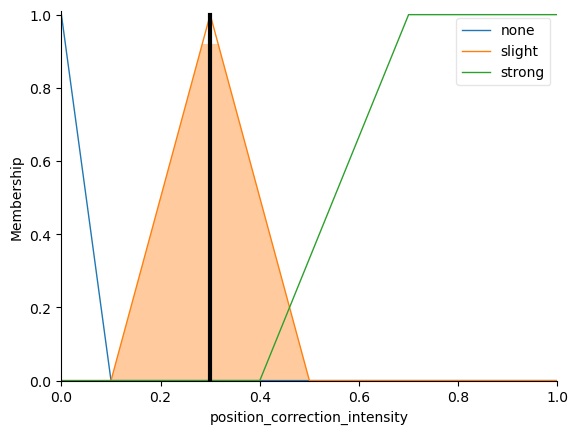

In [105]:
throttle_adjutment.view(sim=landing_sim2)
position_correction_intensity.view(sim=landing_sim2)